Epoch 1/10, Train Loss: 0.32
                Validation Loss: 0.1565 
                Train Accuracy : 81.4188
                Validation Accuracy: 92.0999
Epoch 2/10, Train Loss: 0.1364
                Validation Loss: 0.089 
                Train Accuracy : 93.0298
                Validation Accuracy: 95.3591
Epoch 3/10, Train Loss: 0.0851
                Validation Loss: 0.0608 
                Train Accuracy : 95.7931
                Validation Accuracy: 96.8559
Epoch 4/10, Train Loss: 0.065
                Validation Loss: 0.0451 
                Train Accuracy : 96.6168
                Validation Accuracy: 97.8656
Epoch 5/10, Train Loss: 0.0499
                Validation Loss: 0.0351 
                Train Accuracy : 97.3873
                Validation Accuracy: 98.3615
Epoch 6/10, Train Loss: 0.0357
                Validation Loss: 0.0427 
                Train Accuracy : 98.2464
                Validation Accuracy: 97.7858
Epoch 7/10, Train Loss: 0.0226
                Validatio

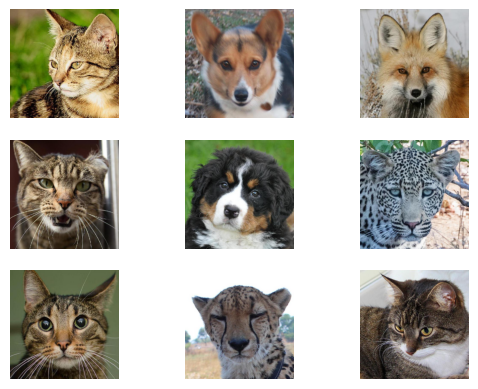

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

image_path = []
labels = []

for i in os.listdir("/kaggle/input/animal-faces/afhq"):
    for label in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}"):
        for image in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}/{label}"):
            image_path.append(f"/kaggle/input/animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)

data_df = pd.DataFrame(zip(image_path,labels), columns = ("image_path", "labels")) #zip pairs up corresponding image paths and labels, which is then converted into a dataframe
train = data_df.sample(frac = 0.7) #takes 70% of the samples
test = data_df.drop(train.index) #drops the data which is in train
val = test.sample(frac = 0.5)
test = test.drop(val.index)

label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"]) #cat,dog,wild are encoded to 0,1,2
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])    

class CustomImageDataset(Dataset):
    def __init__(self, dataframe,transform = None):
        self.dataframe =dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx,0]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image).to(device)
            
        label = self.labels[idx]
        return image,label

train_dataset = CustomImageDataset(dataframe = train,transform = transform)
val_dataset = CustomImageDataset(dataframe = train, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)
#inverse transform?
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows,n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row,col].imshow(image)
        axarr[row,col].axis("off")

lr = 1e-4
batch_size = 16
epochs = 10

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.pooling = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)
        self.output = nn.Linear(128, len(data_df["labels"].unique()))

    def forward(self,x):
        x = self.conv1(x) #32,128,128
        x = self.pooling(x) #32,64,64
        x = self.relu(x)
        
        x = self.conv2(x) # 64,64,64
        x = self.pooling(x) #64,64,32
        x = self.relu(x)
        
        x = self.conv3(x) #64,64,64
        x = self.pooling(x) #64,32,32
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = lr)

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot=[]

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()
        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 1000, 4))
    total_acc_train_plot.append(round((total_acc_train / len(train_dataset)) * 100, 4))
    total_acc_validation_plot.append(round((total_acc_val / len(val_dataset)) * 100, 4))

    print(f"""Epoch {epoch+1}/{epochs}, Train Loss: {round(total_loss_train / 1000, 4)}
                Validation Loss: {round(total_loss_val / 1000, 4)} 
                Train Accuracy : {round((total_acc_train / len(train_dataset)) * 100, 4)}
                Validation Accuracy: {round((total_acc_val / len(val_dataset)) * 100, 4)}""")
        

In [4]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs,labels in test_loader:
        predictions = model(inputs)
        acc = (torch.argmax(predictions,axis=1) == labels).sum().item()
        total_acc_test += acc
        test_loss =criterion(predictions,labels)
        total_loss_test += test_loss.item()

    print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100,4)} and Loss is {round(total_loss_test/1000,4)}")

Accuracy Score is: 95.9074 and Loss is 0.023


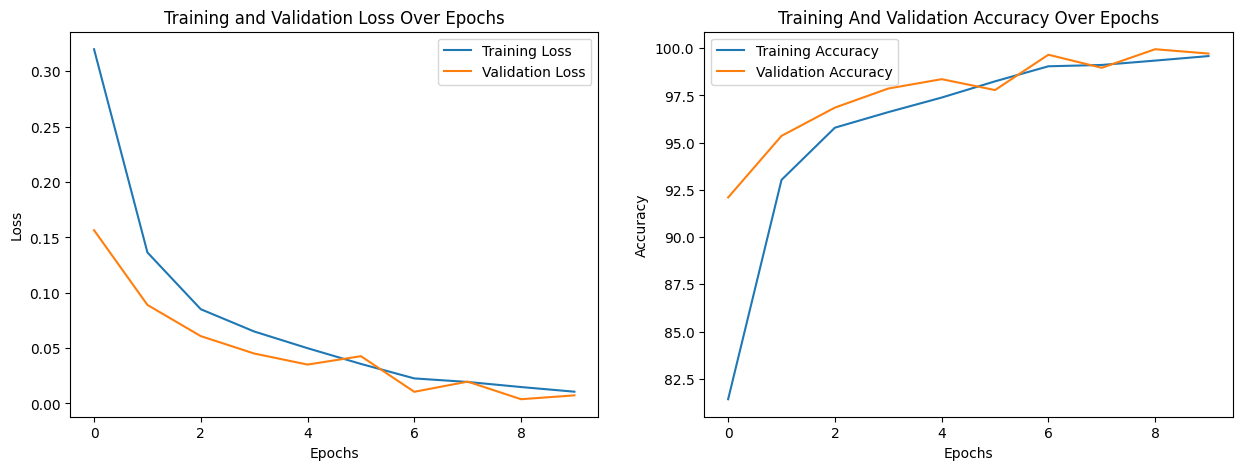

In [5]:
fig, axs = plt.subplots(nrows =1, ncols = 2, figsize = (15,5))
axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_validation_plot, label = "Validation Accuracy")
axs[1].set_title("Training And Validation Accuracy Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

In [ ]:
def predict_image(img_path):
    image = Image.read(img_path).convert("RGB")
    image = transform(image).to(device)
    output = model(image.unsqueeze(0))
    output = torch.argmax(output, axis = 1).item()
    return label_encoder.inverse_transform([output])